# 5G UE-VBS Selection ML Model

## Comparison of 7 Different Clustering Algorithms

In this notebook, we will generate the dataset to build the classification model. This model will determine if a User Equipment (UE) can become a 5G Virtual Base Station (VBS) or not.

- <strong>Environment setup:</strong> import libraries and load the dataset
* <strong>Simulation:</strong> Generating the Co-ordinates of the UEs
* <strong>Clustering:</strong> the UEs based on Distance from the Base Station
* <strong>Comparison of 7 different clustering algorithms:</strong>
    * K-Means
    * Spectral Clustering
    * Agglomerative Clustering
    * Birch
    * Mean Shift
    * Affinity Propagation
    * OPTICS

## Environment Setup

In [1]:
import math
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import OPTICS
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score

## Generating the Co-ordinates of the UEs


### Helper for generating the co-ordinates


In [2]:
def get_coordinates(number_of_ue_devices = 100, max_range=100):
    # default number of UE devices = 100
    coordinates = []

    for i in range(number_of_ue_devices):
        # Return the next random floating point number in the range [0.0, 1.0) - random.random()
        # By multiplying with 1000, the effective range shifts to [0, 1000) 
        coordinates.append([(random.random() * max_range), (random.random() * max_range)])
    return np.array(coordinates)

In [3]:
# initial coordinates at T1
number_of_ue_devices = 100
max_range = 1000
c = get_coordinates(number_of_ue_devices, max_range)

# Constant Parameters for propogation

dt = 20 #time interval
speed = [ random.randint(-10, 10) for _ in range(number_of_ue_devices) ]; # random speeds
angle =  [ random.randint(10, 350) for _ in range(number_of_ue_devices)] ; # random angles

# Base-Station Coordintes 
base_station_coordinates = [[500, 500]]

# At Time-0
x_1 = np.array([ i[0] for i in c ])
y_1 = np.array([ i[1] for i in c ])

# At Time-1
x_2 = [ x_1[i] + (speed[i] * dt) for i in range(number_of_ue_devices)]
y_2 = [ y_1[i] + (math.cos(angle[i]) * math.pi / 180) * dt for i in range(number_of_ue_devices)]

# At Time-2
x_3 = [ x_2[i] + (speed[i] * dt) for i in range(number_of_ue_devices)]
y_3 = [ y_2[i] + (math.cos(angle[i]) * math.pi / 180) * dt for i in range(number_of_ue_devices)]

### Visualizing the movement of the UEs

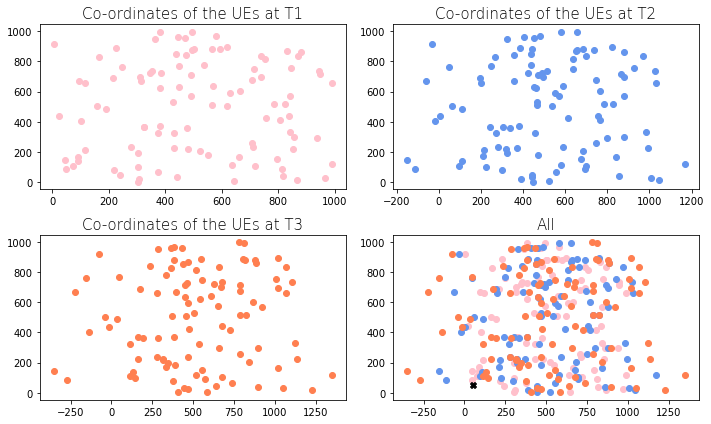

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
# fig.suptitle("Visualizing the movement of the UEs", fontsize='20', fontweight='light')
axs[0, 0].scatter(x_1, y_1, c='pink')
axs[0, 0].set_title("Co-ordinates of the UEs at T1", fontsize='15', fontweight='light')
axs[0, 1].scatter(x_2, y_2, c='cornflowerblue')
axs[0, 1].set_title("Co-ordinates of the UEs at T2", fontsize='15', fontweight='light')
axs[1, 0].scatter(x_3, y_3, c='coral')
axs[1, 0].set_title("Co-ordinates of the UEs at T3", fontsize='15', fontweight='light')
axs[1, 1].scatter(x_1, y_1, c='pink')
axs[1, 1].scatter(x_2, y_2, c='cornflowerblue')
axs[1, 1].scatter(x_3, y_3, c='coral')
axs[1, 1].scatter(50, 50, marker='X', c='black')
axs[1, 1].set_title("All", fontsize='15', fontweight='light')
fig.tight_layout()

## Clustering the UEs based on Distance from the Base Station

### Determining the ideal value for the number of clusters

The <strong>Silhouette Score</strong> and <strong>Silhouette Plot</strong> are used to measure the separation distance between clusters. It displays a measure of how close each point in a cluster is to points in the neighbouring clusters. This measure has a range of <strong>[-1, 1]</strong> and is a great tool to visually inspect the similarities within clusters and differences across clusters.<br>
<strong>Silhouette Score</strong> is calculated using the mean <strong>intra-cluster distance (i)</strong>
<strong>mean nearest-cluster distance (n)</strong> for each sample.<br>
The <strong>Silhouette Coefficient</strong> for a sample is <strong>(n - i) / max(i, n)</strong>.
- <strong>n</strong>: is the distance between each sample and the nearest cluster that the sample is not a part of
- <strong>i</strong>: is the mean distance within each cluster
    
Important Points about Silhouette Plots:
- The typical Silhouette Plots represent the cluster label on the y-axis, while the actual Silhouette Score on the x-axis
- The size/thickness of the silhouettes is also proportional to the number of samples inside that cluster
- The higher the Silhouette Coefficients (the closer to +1), the further away the cluster’s samples are from the neighbouring clusters samples
- A value of 0 indicates that the sample is on or very close to the decision boundary between two neighbouring clusters
- Negative values, instead, indicate that those samples might have been assigned to the wrong cluster
- Averaging the Silhouette Coefficients, we can get to a global Silhouette Score which can be used to describe the entire population’s performance with a single value

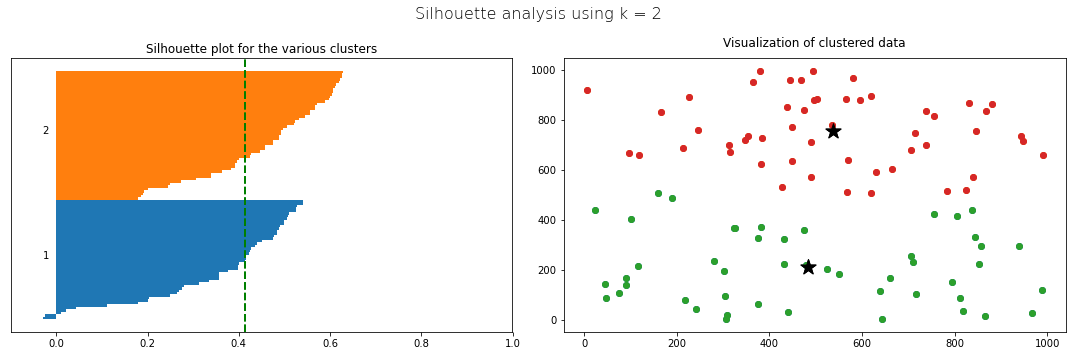

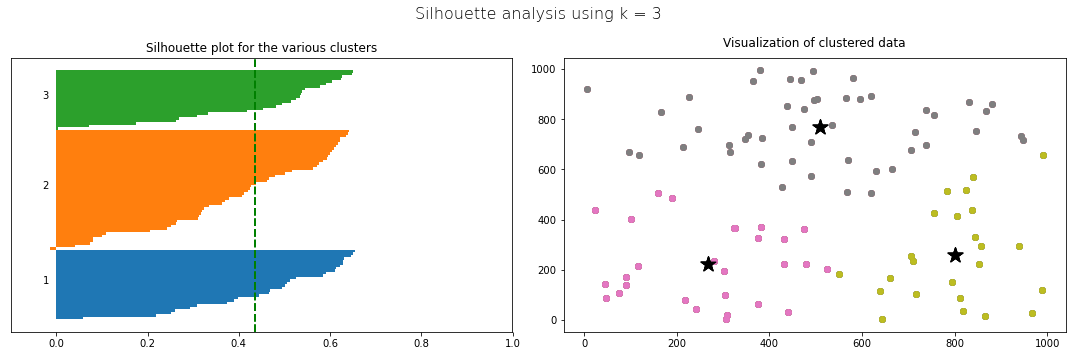

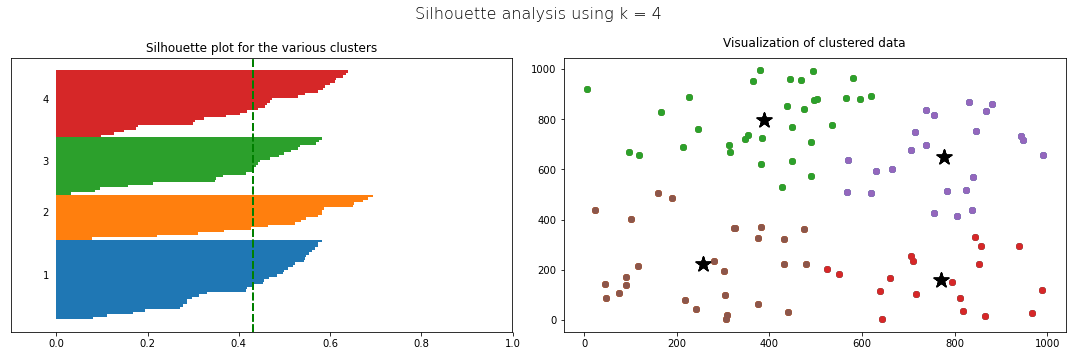

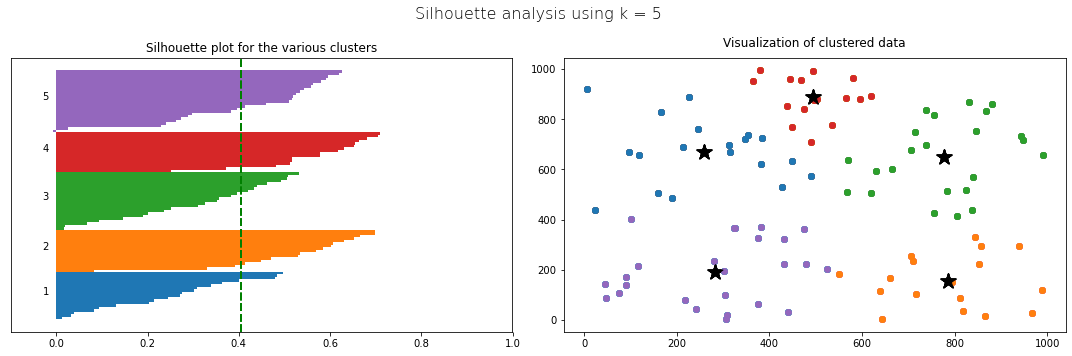

In [5]:
for i,k in enumerate([2,3,4,5]):
    
    fig, ax = plt.subplots(1,2,figsize=(15,5))

    # Run the kmeans algorithm
    km = KMeans(n_clusters=k)
    y_predict = km.fit_predict(c)
    centroids = np.unique(y_predict)
    
    # get silhouette
    silhouette_vals = silhouette_samples(c, y_predict)

    # silhouette plot
    y_ticks = []
    y_lower = y_upper = 0

    for i, cluster in enumerate(np.unique(y_predict)):
        cluster_silhouette_vals = silhouette_vals[y_predict ==cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)

        ax[0].barh(range(y_lower,y_upper), cluster_silhouette_vals,height =1);
        ax[0].text(-0.03,(y_lower+y_upper)/2,str(i+1))
        y_lower += len(cluster_silhouette_vals)

        # Get the average silhouette score 
        avg_score = np.mean(silhouette_vals)
        ax[0].axvline(avg_score,linestyle ='--', linewidth =2,color = 'green')
        ax[0].set_yticks([])
        ax[0].set_xlim([-0.1, 1])
        ax[0].set_title('Silhouette plot for the various clusters');


        # scatter plot of data colored with labels
        for cl in centroids:
            row_ix = np.where(y_predict == cl)
            ax[1].scatter(c[row_ix, 0], c[row_ix, 1])
            
        cl_centres = km.cluster_centers_
            
        ax[1].scatter(cl_centres[:, 0], cl_centres[:, 1], marker = '*' , c= 'black',s =250);
        ax[1].set_title('Visualization of clustered data', y=1.02)

        plt.tight_layout()
        plt.suptitle(f' Silhouette analysis using k = {k}',fontsize=16, fontweight = 'light')
    #     plt.savefig(f'Silhouette_analysis_{k}.jpg')

## Generating Different Clustering Models

### K-Means

Number of clusters: 4
Silhouette Coefficient: 0.432


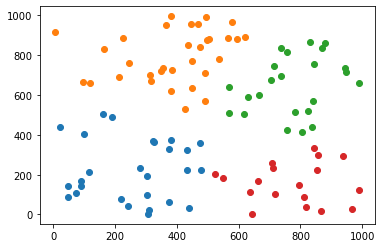

In [6]:
model_1 = KMeans(n_clusters=4, random_state=42)
model_1.fit(c)
yhat_1 = model_1.predict(c)
clusters_1 = np.unique(yhat_1)

cluster_centers = model_1.cluster_centers_
labels = model_1.labels_
n_clusters_ = len(cluster_centers)
print("Number of clusters: %d" % n_clusters_)
print(
    "Silhouette Coefficient: %0.3f"
    % silhouette_score(c, labels, metric="euclidean")
)

fig = plt.figure()
for cluster in clusters_1:
	row_ix = np.where(yhat_1 == cluster)
	plt.scatter(c[row_ix, 0], c[row_ix, 1])

fig.savefig("Fig/02-01-KMeans_Clustering.png")
fig.savefig("Eps/02-01-KMeans_Clustering.eps", format='eps')
plt.show()

### Mean Shift

Estimated number of clusters: 3
Silhouette Coefficient: 0.429


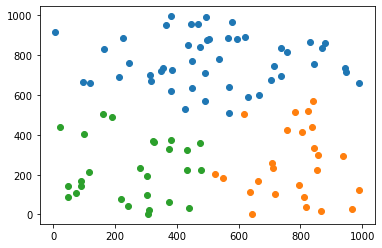

In [7]:
# hyper-parameter: bandwidth: for further documentation -> https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html?highlight=meanshift#sklearn.cluster.MeanShift
bandwidth = estimate_bandwidth(c, quantile=0.2, n_samples=number_of_ue_devices)

model_2 = MeanShift(bandwidth=bandwidth)
yhat_2 = model_2.fit_predict(c) # various cluster ids
clusters_2 = np.unique(yhat_2)

cluster_centers = model_2.cluster_centers_
labels = model_2.labels_
n_clusters_ = len(cluster_centers)
print("Estimated number of clusters: %d" % n_clusters_)
print(
    "Silhouette Coefficient: %0.3f"
    % silhouette_score(c, labels, metric="euclidean")
)

fig = plt.figure()
for cluster in clusters_2:
	row_ix = np.where(yhat_2 == cluster)
	plt.scatter(c[row_ix, 0], c[row_ix, 1])    

fig.savefig("Fig/02-02-MeanShift_Clustering.png")
fig.savefig("Eps/02-02-MeanShift_Clustering.eps", format='eps')
plt.show()

### Affinity Propagation

Estimated number of clusters: 8
Silhouette Coefficient: 0.393


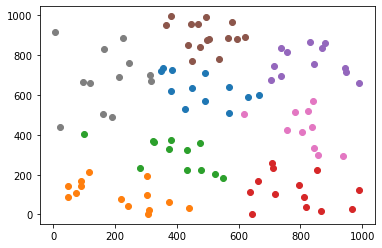

In [8]:
model_3 = AffinityPropagation(random_state=42)
model_3.fit(c)
yhat_3 = model_3.fit_predict(c)
clusters_3 = np.unique(yhat_3)

cluster_centers_indices = model_3.cluster_centers_indices_
labels = model_3.labels_
n_clusters_ = len(cluster_centers_indices)
print("Estimated number of clusters: %d" % n_clusters_)
print(
    "Silhouette Coefficient: %0.3f"
    % silhouette_score(c, labels, metric="euclidean")
)

plt.figure()
for cluster in clusters_3:
	row_ix = np.where(yhat_3 == cluster)
	plt.scatter(c[row_ix, 0], c[row_ix, 1])

fig.savefig("Fig/02-03-AffinityPropagation_Clustering.png")
fig.savefig("Eps/02-03-AffinityPropagation_Clustering.eps", format='eps')
plt.show()

### Spectral Clustering

Number of clusters: 4
Silhouette Coefficient: 0.425


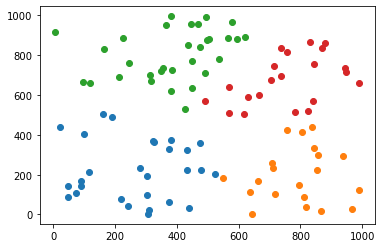

In [9]:
model_4 = SpectralClustering(n_clusters=4, affinity="nearest_neighbors", random_state=42)
model_4.fit(c)
yhat_4 = model_4.fit_predict(c)
clusters_4 = np.unique(yhat_4)

labels = model_4.labels_
n_clusters_ = len(clusters_4)

print("Number of clusters: %d" % n_clusters_)
print(
    "Silhouette Coefficient: %0.3f"
    % silhouette_score(c, labels, metric="euclidean")
)

fig = plt.figure()
for cluster in clusters_4:
	row_ix = np.where(yhat_4 == cluster)
	plt.scatter(c[row_ix, 0], c[row_ix, 1])

fig.savefig("Fig/02-04-Spectral_Clustering.png")
fig.savefig("Eps/02-04-Spectral_Clustering.eps", format='eps')
plt.show()

### Agglomerative Clustering

Number of clusters: 4
Silhouette Coefficient: 0.384


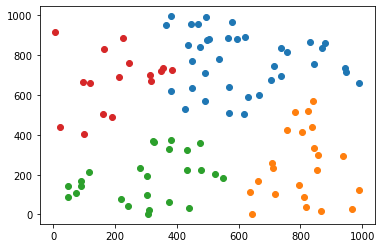

In [10]:
model_5 = AgglomerativeClustering(n_clusters=4)
model_5.fit(c)
yhat_5 = model_5.fit_predict(c)
clusters_5 = np.unique(yhat_5)

labels = model_5.labels_
n_clusters_ = len(clusters_5)

print("Number of clusters: %d" % n_clusters_)
print(
    "Silhouette Coefficient: %0.3f"
    % silhouette_score(c, labels, metric="euclidean")
)

fig = plt.figure()
for cluster in clusters_5:
	row_ix = np.where(yhat_5 == cluster)
	plt.scatter(c[row_ix, 0], c[row_ix, 1])
    
fig.savefig("Fig/02-05-Agglomerative_Clustering.png")
fig.savefig("Eps/02-05-Agglomerative_Clustering.eps", format='eps')
plt.show()

### OPTICS

Estimated number of clusters: 6
Silhouette Coefficient: 0.009


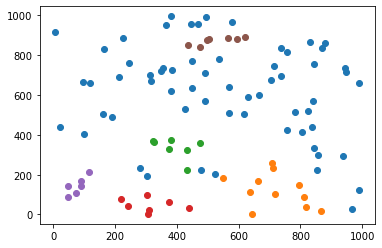

In [11]:
model_6 = OPTICS()
model_6.fit(c)
yhat_6 = model_6.fit_predict(c)
clusters_6 = np.unique(yhat_6)

labels = model_6.labels_
n_clusters_ = len(clusters_6)

print("Estimated number of clusters: %d" % n_clusters_)
print(
    "Silhouette Coefficient: %0.3f"
    % silhouette_score(c, labels, metric="euclidean")
)

fig = plt.figure()
for cluster in clusters_6:
	row_ix = np.where(yhat_6 == cluster)
	plt.scatter(c[row_ix, 0], c[row_ix, 1])

fig.savefig("Fig/02-06-Optics_Clustering.png")
fig.savefig("Eps/02-06-Optics_Clustering.eps", format='eps')
plt.show()

### Birch

Number of clusters: 4
Silhouette Coefficient: 0.384


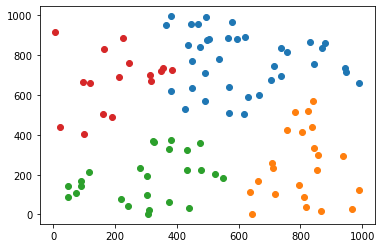

In [12]:
model_7 = Birch(n_clusters=4)
model_7.fit(c)
yhat_7 = model_7.fit_predict(c)
clusters_7 = np.unique(yhat_7)

labels = model_7.labels_
n_clusters_ = len(clusters_7)

print("Number of clusters: %d" % n_clusters_)
print(
    "Silhouette Coefficient: %0.3f"
    % silhouette_score(c, labels, metric="euclidean")
)

fig = plt.figure()
for cluster in clusters_7:
	row_ix = np.where(yhat_7 == cluster)
	plt.scatter(c[row_ix, 0], c[row_ix, 1])

fig.savefig("Fig/02-07-Birch_Clustering.png")
fig.savefig("Eps/02-07-Birch_Clustering.eps", format='eps')
plt.show()

## Comparing K-Means and Mean Shift

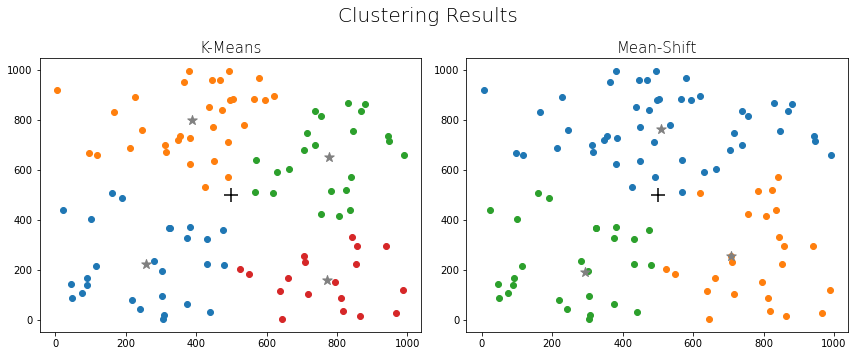

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Clustering Results", fontsize='20', fontweight='light')

# K-Means
ax1.set_title("K-Means", fontsize='15', fontweight='light')

for cluster in clusters_1:
    row_ix = np.where(yhat_1 == cluster)
    ax1.scatter(c[row_ix, 0], c[row_ix, 1])

# Cluster Centers
ax1.scatter(model_1.cluster_centers_[:, 0], model_1.cluster_centers_[:, 1], s=100, c='grey', marker='*')
# Base Station
ax1.scatter(500, 500, s=200, c='black', marker="+")

# Mean-Shift
ax2.set_title("Mean-Shift", fontsize='15', fontweight='light')

for cluster in clusters_2:
    row_ix = np.where(yhat_2 == cluster)
    ax2.scatter(c[row_ix, 0], c[row_ix, 1])

# Cluster Centers
ax2.scatter(model_2.cluster_centers_[:, 0], model_2.cluster_centers_[:, 1], s=100, c='grey', marker='*')
    
# Base Stattion
ax2.scatter(500, 500, s=200, c='black', marker="+")
fig.tight_layout()

### Performace comaparison between all the clustering algorithms


In [14]:
print("K-Means: %0.3f" % silhouette_score(c, yhat_1, metric='euclidean'))
print("Spectral Clustering: %0.3f" % silhouette_score(c, yhat_4, metric='euclidean'))
print("Agglomerative Clustering: %0.3f" % silhouette_score(c, yhat_5, metric='euclidean'))
print("Birch: %0.3f" % silhouette_score(c, yhat_7, metric='euclidean'))

print()

print("Mean Shift: %0.3f" % silhouette_score(c, yhat_2, metric='euclidean'))
print("Affinity Propagation: %0.3f" % silhouette_score(c, yhat_3, metric='euclidean'))
print("OPTICS: %0.3f" % silhouette_score(c, yhat_6, metric='euclidean'))

K-Means: 0.432
Spectral Clustering: 0.425
Agglomerative Clustering: 0.384
Birch: 0.384

Mean Shift: 0.429
Affinity Propagation: 0.393
OPTICS: 0.009
